In [2]:
import matplotlib.pylab as plt
from astropy.io import fits
import numpy as np
import pandas as pd
import os
import scipy.interpolate
from scipy.interpolate import splev, splrep

In [3]:
star = 'GJ251'
Wave_Path = '/mnt_home/malikb/code/keck_rwav.fits'
Flux_Path = '/mnt_home/malikb/code/rj237.279.fits'

wl_file = fits.open(Wave_Path)
fl_file = fits.open(Flux_Path)
wl_image = wl_file[0].data
fl_image = fl_file[0].data

In [4]:
wl_image

array([[4976.64794645, 4976.67138727, 4976.6948278 , ..., 5064.74141172,
        5064.76122055, 5064.78102816],
       [5047.72743059, 5047.75121338, 5047.77499587, ..., 5137.10243553,
        5137.12253196, 5137.14262715],
       [5120.86875527, 5120.89288941, 5120.91702325, ..., 5211.5604427 ,
        5211.58083461, 5211.60122526],
       ...,
       [6092.01496989, 6092.04370168, 6092.0724331 , ..., 6199.93030636,
        6199.95456012, 6199.97881238],
       [6198.90400873, 6198.93323802, 6198.96246693, ..., 6308.68187614,
        6308.70654698, 6308.73121629],
       [6309.61430863, 6309.64405136, 6309.67379371, ..., 6421.3140896 ,
        6421.33919069, 6421.36429021]])

In [5]:
wl_image[11,36]

5889.935433375593

In [6]:
wl_image[11,252]

5895.923320801434

Magnesium

In [7]:
wl_image[2,2702]

5183.638136066654

In [8]:
wl_image[2,2211]

5172.704524869108

In [9]:
wl_image[2,1974]

5167.339180227374

Mercury

In [10]:
wl_image[6,976]

5460.734639641085

In [11]:
wl_image[11:12]

array([[5888.93551822, 5888.96329999, 5888.9910814 , ..., 5993.29340472,
        5993.31686153, 5993.34031689]])

In [12]:
print(4976.671387267135-4976.64794644686)

0.023440820275027363


In [13]:
print(wl_image[0,1]-wl_image[0,0])

0.023440820275027363


In [14]:
wl_image[-1,-1]

6421.364290210344

In [15]:
wl_image[-1,-2]

6421.339190687356

In [16]:
print(wl_image[11,252]-wl_image[11,37])

5.960118890647209


In [17]:
np.min(wl_image)

4976.64794644686

In [18]:
print(wl_image[-1,-1]/(wl_image[-1,-1]-wl_image[-1,-2]))

255836.10864898592


In [19]:
print(wl_image[0,0]/(wl_image[0,1]-wl_image[0,0]))

212306.90257664418


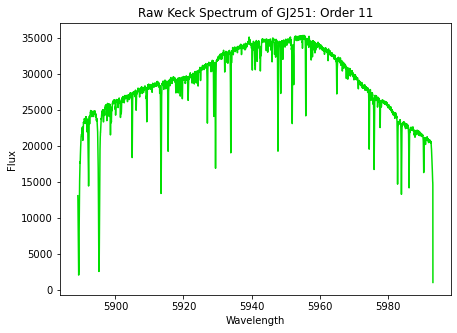

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

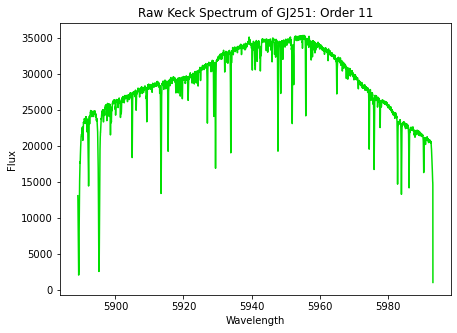

In [20]:
plt.rcParams["figure.figsize"] = (7,5)

order = 11
wave = (wl_image[order])
flux = (fl_image[order])

plt.plot(wave,flux, "#01DF01")

plt.title('Raw Keck Spectrum of ' + star + ': Order ' + str(order))
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show(np.median(fl_image, axis=0, keepdims=True))

In [21]:
bias = np.median(wl_image[-30:])
print(bias)

5614.096265287181


Text(0, 0.5, 'Flux')

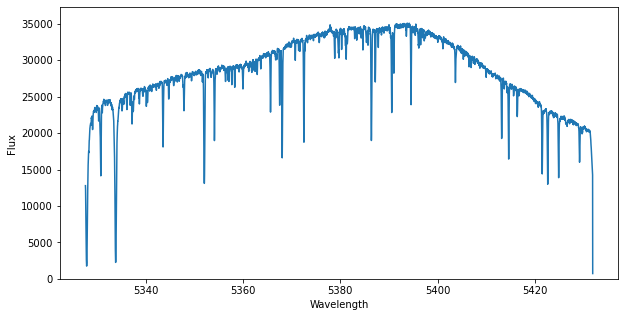

In [22]:
plt.figure(figsize=(10,5))
wave_adjusted = wave - (0.1*bias)
flux_adjusted = flux - (0.05*bias)
plt.plot(wave_adjusted, flux_adjusted)
ymax = np.median(flux_adjusted)*1.3
plt.ylim(0,ymax)
plt.xlabel('Wavelength')
plt.ylabel('Flux')

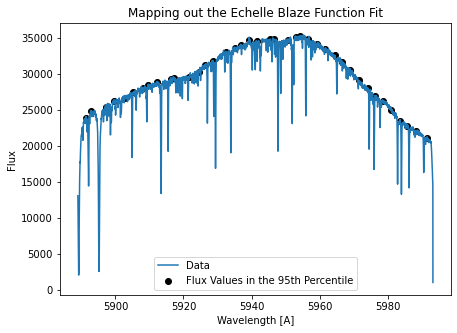

In [23]:
bin = 100

# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wave) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wave_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wave_values = np.append(wave_values, wave[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wave, flux, label = 'Data')
plt.scatter(wave_values, fl_values, color = 'black', label = 'Flux Values in the 95th Percentile')
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

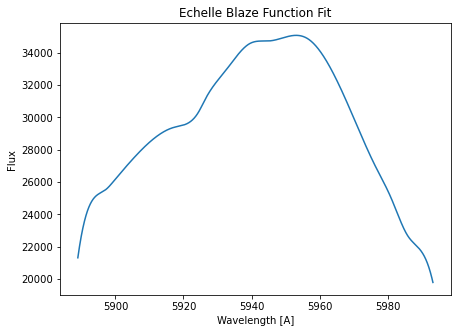

In [24]:
spl = splrep(wave_values, fl_values, s = 500000)
flux_fit = splev(wave, spl)
plt.plot(wave, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

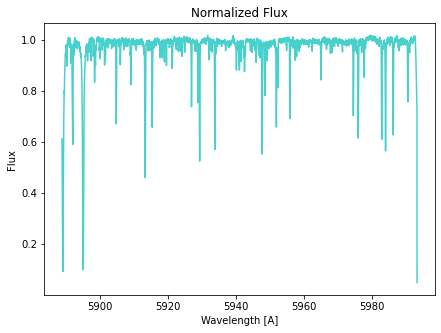

In [25]:
first_normalized_flux = flux / flux_fit
plt.plot(wave, first_normalized_flux, "#48D1CC")
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Normalized Flux')
plt.show()

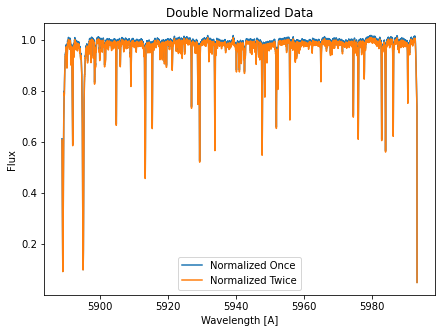

In [26]:
flux98 = np.percentile(first_normalized_flux, 98)
normalized_flux = first_normalized_flux / flux98

plt.plot(wave, first_normalized_flux, label = 'Normalized Once')
plt.plot(wave, normalized_flux, label = 'Normalized Twice')
plt.legend()
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Double Normalized Data')
plt.show()